In [3]:
from leibnizgym.envs.trifinger import TrifingerEnv
from isaacgym import gymtorch
from isaacgym.torch_utils import *
from leibnizgym.utils import fop, torch_utils
import torch

Importing module 'gym_38' (/scr-ssd/ksrini/Downloads/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /scr-ssd/ksrini/Downloads/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 1.10.0+cu102
Device count 1
/scr-ssd/ksrini/Downloads/isaacgym/python/isaacgym/_bindings/src/gymtorch
Using /afs/cs.stanford.edu/u/ksrini/.cache/torch_extensions/py38_cu102 as PyTorch extensions root...
Emitting ninja build file /afs/cs.stanford.edu/u/ksrini/.cache/torch_extensions/py38_cu102/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module gymtorch...
WARNING - pyDR not installed. Domain Randomization functionality will not be available.


In [4]:
env_config = dict(num_instances=2,
     aggregate_mode=False,
     control_decimation=True,
     command_mode="fingertip_pos_torque",
     sim=dict(use_gpu_pipeline=True, physx=dict(use_gpu=True)))
env = TrifingerEnv(config=env_config, device='cuda:0', verbose=False, visualize=False)

[INFO] [2021.11.18::03-13-16]: [env_base]: Observations: 41
    robot_q: 9
    robot_u: 9
    object_q: 7
    object_q_des: 7
    command: 9
[INFO] [2021.11.18::03-13-16]: [env_base]: States: 113
    robot_q: 9
    robot_u: 9
    object_q: 7
    object_q_des: 7
    command: 9
    object_u: 6
    fingertip_state: 39
    robot_a: 9
    fingertip_wrench: 18
[INFO] [2021.11.18::03-13-16]: [env_base]: Action: 9
    command: 9
--------------------
[INFO] [2021.11.18::03-13-16]: [env_base]: Simulation physics parameters: 
<isaacgym._bindings.linux-x86_64.gym_38.SimParams object at 0x7ff83204ddf0>
Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
[INFO] [2021.11.18::03-13-20]: [trifinger_env]: Trifinger Robot Asset: 
	 Number of bodies: 17
	 Number of shapes: 15
	 Number of dofs: 9
	 Number of actuated dofs: 9
[INFO] [2021.11.18::03-13-20]: [trifinger_env]: Trifinger Stage Asset: 
	 Number of bodies: 1
	 Number of shapes: 40
[INFO] [202

In [5]:
env._lmbda = 0.05
obs = env.reset()
ftip_dirs = []
last_dist = 1
larger_dist_ct = 0
for i in range(150):
    cp_params = to_torch([[0,1.,0],[1.,0,0],[-1.,0,0]]) * 0.0335
    q, t = env._object_state_history[0][:, 3:7], env._object_state_history[0][:, :3]
    q = q.view((2, 1, 4)).tile(1, 3, 1).view(-1, 4)
    t = t.view((2, 1, 3)).tile(1, 3, 1).view(-1, 3)
    cp_wf = tf_apply(q, cp_params.repeat(2, 1), t).reshape(2, 3, 3)
    ftip_pos = env._fingertips_frames_state_history[0][:, :, :3]
    ftip_dir = cp_wf - ftip_pos
    ftip_dir = ftip_dir.view(2, 9)
    ftip_dist = torch.norm(ftip_dir, dim=1).sum() / 2
    ftip_dirs.append(ftip_dist)
    # check if dist is getting smaller
    if ftip_dist > last_dist:
        larger_dist_ct += 1
    elif larger_dist_ct < 3:
        larger_dist_ct = 0
    last_dist = min(ftip_dirs)
    # set action for next step to either current ftip_pos, goal, or clipped pos offset
    if larger_dist_ct > 3:
        if 'offset' in env.config['command_mode']:
            ac = ftip_pos.reshape(2, 9) * 0.
        else:
            ac = ftip_pos.reshape(2, 9)  # no change from last 
    elif 'offset' not in env.config['command_mode']:
        ac = cp_wf.view(2, 9)
    else:
        ac = torch_utils.saturate(ftip_dir, env._action_scale.low, 
                                  env._action_scale.high)
    # scale transform action
    if env.config['normalize_action']:
        ac = torch_utils.scale_transform(ac, env._action_scale.low, 
                                         env._action_scale.high)
    if torch.norm(ftip_dir) < 0.1:
        break
    obs, r, d, i = env.step(ac)

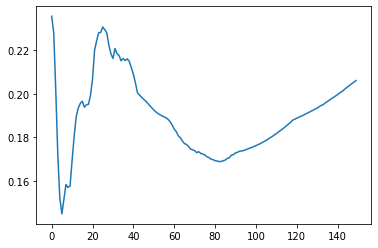

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([x.detach().cpu().numpy() for x in ftip_dirs])

In [11]:
cp_params = to_torch([[0,1.,0],[1.,0,0],[-1.,0,0]])
q, t = env._object_state_history[0][:, 3:7], env._object_state_history[0][:, :3]
q = q.view((2, 1, 4)).tile(1, 3, 1).view(-1, 4)
t = t.view((2, 1, 3)).tile(1, 3, 1).view(-1, 3)
cp_wf = tf_apply(q, cp_params.repeat(2, 1), t).reshape(2, 3, 3)
ac = cp_wf.view(2, 9)
ftip_pos = env._fingertips_frames_state_history[0][:, :, :3]
ftip_dir = cp_wf - ftip_pos
ftip_dirs.append(ftip_dir)
obs, r, d, i = env.step(ac)
# ftip_dir = ftip_dir.view(2, 9)
# ac = torch_utils.saturate(ftip_dir, env._action_scale.low, 
#                           env._action_scale.high)
# if env.config['normalize_action']:
#     ac = torch_utils.scale_transform(ac, env._action_scale.low, 
#                                      env._action_scale.high)

# ac

In [69]:
env.config['asymmetric_obs']

True

In [65]:
torch_utils.scale_transform(ftip_dir, env._action_scale.low, env._action_scale.high)

tensor([[ 0.0420,  9.3683, -0.6246, 10.7841,  0.9688, -0.6246, -8.2010, -0.4741,
         -0.6246],
        [-1.7513,  9.0308, -0.6346,  9.0005,  0.6372, -0.6845, -9.9943, -0.8116,
         -0.6346]], device='cuda:0')

In [50]:
env.step(ftip_dir.reshape(2, 9))

ValueError: Invalid shape for tensor `action`. Input: (2, 3, 3) != (2, 9).

In [4]:
prob = fop.BatchForceOptProblem()
obs = env.reset()
cp_list = env._fingertips_frames_state_history[0][:,:,:7]
G = prob.get_grasp_matrix(cp_list)

In [ ]:
W = torch.randn((2, 6), device=env.device, dtype=torch.float)
prob(W, cp_list)

/scr1/.pyenv/versions/rlgpu/lib/python3.8/site-packages/diffcp/cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


tensor([[  5.5309,   5.5309,  -1.1009,   6.1563,   4.2820,   6.1563,   6.6669,
           4.1566,  -4.6922],
        [ 32.0668,  31.7971,  14.1736,  30.0242,  29.7944, -26.1325,  32.7149,
          32.4041,   6.8525]], device='cuda:0')

In [ ]:
def _get_grasp_matrix_single_cp(cp_wf):
    P = prob._get_P_matrix(cp_wf[:, :3])  # n x 6 x 6
    quat_c_2_w = cp_wf[:, 3:]

    # Orientation of cp frame w.r.t. world frame
    # quat_c_2_w = quat_o_2_w * quat_c_2_o
    # R is rotation matrix from contact frame i to world frame
    R = fop.euler_angles_to_matrix(torch.stack(get_euler_xyz(quat_c_2_w), dim=-1))
    _R0 = torch.zeros_like(R)  # n x 3 x 3
    R_bar = torch.cat((torch.cat([R, _R0], dim=-1),  # concat columns
                       torch.cat([_R0, R], dim=-1)), dim=-2)  # then rows 
    G = torch.bmm(P, R_bar)  # n x 6 x 6
    return G.transpose(1, 2)


GT_list = []
n = len(cp_list)
H = fop._get_H_matrix().unsqueeze(0).tile((n, 1, 1))  # n x 9 x 18

for i in range(3):
    cp_wf = cp_list[:, i]
    GT_i = _get_grasp_matrix_single_cp(cp_wf)
    GT_list.append(GT_i)
GT_full = torch.cat(GT_list, dim=1)  # n x 18 x 6
GT = torch.bmm(H, GT_full)  # n x 9 x 6

In [ ]:
def compute_torque(ftip_force):
    env._gym.refresh_jacobian_tensors(env._sim)
    torque = 0
    for fid, frame_id in enumerate(env._fingertips_handles.values()):
        Ji = Ji_t[:, frame_id - 1, :3]
        Ji_T = Ji.transpose(1, 2)
        F = ftip_force[:, 3 * fid: 3 * fid + 3]
        torque += .5 * torch.matmul(Ji_T, F)
    return torque

In [23]:
def random_ftip_force():
    ac = torch.rand(env.get_action_shape(), dtype=torch.float, device=env.device)
    ac = ac.view(-1, 9, 1)
    return compute_torque(ac)

In [14]:
env._dof_state.shape

torch.Size([128, 9, 2])

In [17]:
action = 2 * torch.rand(env.get_action_shape(), dtype=torch.float, device=env.device) - 1

In [18]:
_, _, _, _ = env.step(action)

In [20]:
link_dict = env._gym.get_asset_rigid_body_dict(env._gym_assets['robot'])
dof_dict = env._gym.get_asset_dof_dict(env._gym_assets['robot'])

In [25]:
env._gym.refresh_jacobian_tensors(env._sim)

True

In [29]:
env._fingertips_handles

OrderedDict([('finger_tip_link_0', 6),
             ('finger_tip_link_120', 11),
             ('finger_tip_link_240', 16)])

In [24]:
link_dict

{'base_link': 0,
 'finger_base_link_0': 2,
 'finger_base_link_120': 7,
 'finger_base_link_240': 12,
 'finger_lower_link_0': 5,
 'finger_lower_link_120': 10,
 'finger_lower_link_240': 15,
 'finger_middle_link_0': 4,
 'finger_middle_link_120': 9,
 'finger_middle_link_240': 14,
 'finger_tip_link_0': 6,
 'finger_tip_link_120': 11,
 'finger_tip_link_240': 16,
 'finger_upper_link_0': 3,
 'finger_upper_link_120': 8,
 'finger_upper_link_240': 13,
 'upper_holder_link': 1}